# Decision Tree

##### Importing the Dataset

In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyodbc
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.tree import export_text, DecisionTreeClassifier
from sklearn.model_selection import train_test_split




conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=..\Data\go_sales_schoon.accdb;')
cursor = conn.cursor()
#WHY THE FUCK DOES ACCESS REQUIRE BRACKETS FOR MORE THAN ONE JOIN AND WHY DIT IT TAKE SO LONG FOR ME TO FIND THIS INFO REEEEEEEEEEEEEEEEEEEEE
sql = """
SELECT *
FROM (((((returned_item
INNER JOIN return_reason
ON returned_item.RETURN_REASON_CODE = return_reason.RETURN_REASON_CODE)
INNER JOIN order_details
ON returned_item.ORDER_DETAIL_CODE = order_details.ORDER_DETAIL_CODE)
INNER JOIN order_header
ON order_header.ORDER_NUMBER = order_details.ORDER_NUMBER)
INNER JOIN sales_sales_branch
ON sales_sales_branch.SALES_BRANCH_CODE = order_header.SALES_BRANCH_CODE)
INNER JOIN product
ON product.PRODUCT_NUMBER = order_details.PRODUCT_NUMBER)
INNER JOIN product_type
ON product_type.PRODUCT_TYPE_CODE = product.PRODUCT_TYPE_CODE
"""
cursor.execute(sql)
data = cursor.fetchall()

columns = [column[0] for column in cursor.description]

formatted_data = {}

for i in range(len(columns)):
    dataList = []
    for j in data:
        dataList.append(j[i])
    formatted_data[columns[i]] = dataList

df = pd.DataFrame(data=formatted_data,columns=columns)
df

,RETURN_CODE,RETURN_DATE,ORDER_DETAIL_CODE,RETURN_REASON_CODE,RETURN_QUANTITY,RETURN_REASON_CODE,RETURN_DESCRIPTION_EN,ORDER_DETAIL_CODE,ORDER_NUMBER,PRODUCT_NUMBER,...,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_IMAGE,LANGUAGE,PRODUCT_NAME,DESCRIPTION,PRODUCT_TYPE_CODE,PRODUCT_LINE_CODE,PRODUCT_TYPE_EN
0,1784,2-1-2023 06:16:02,52165,1,2,1,Defective product,52165,1836,22,...,3,10,.33,P22CE1SB3.jpg,EN,Hibernator Pillow,"Camp pillow is filled with soft, luxurious fib...",3,1,Sleeping Bags
1,1770,19-1-2022 21:53:58,51056,2,2,2,Incomplete product,51056,1853,3,...,1,15.93,.28,P03CE1CG1.jpg,EN,TrailChef Kitchen Kit,"Zippered nylon pouch contains cutlery for two,...",1,1,Cooking Gear
2,1793,3-12-2020 08:21:11,50607,5,66,5,Unsatisfactory product,50607,1860,38,...,5,20,.33,P38CE1LT5.jpg,EN,EverGlow Kerosene,One of the most dependable sources of light in...,5,1,Lanterns
3,1783,22-7-2020 08:22:41,50491,2,2,2,Incomplete product,50491,1888,22,...,3,10,.33,P22CE1SB3.jpg,EN,Hibernator Pillow,"Camp pillow is filled with soft, luxurious fib...",3,1,Sleeping Bags
4,1778,1-9-2022 20:51:55,52107,5,70,5,Unsatisfactory product,52107,1913,15,...,2,490,.33,P15CE1TN2.jpg,EN,Star Gazer 6,Massive cabin tent has ample room for six peop...,2,1,Tents
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,2020,8-2-2022 11:29:22,103301,1,4,1,Defective product,103301,9193,47,...,7,44.83,.31,P47ME2SY7.jpg,EN,Husky Harness,One size fits all due to extensive waist belt ...,7,2,Safety
702,2316,1-11-2022 00:00:09,104946,2,4,2,Incomplete product,104946,9211,44,...,6,231.11,.33,P44ME2RP6.jpg,EN,Husky Rope 100,11 mm diameter standard rope. Length: 100 m. ...,6,2,Rope
703,2066,17-10-2022 10:24:45,105181,1,4,1,Defective product,105181,9214,78,...,13,79.19,.2,P78PA3BN13.jpg,EN,Seeker 35,This 7 x 35 model is economical and performs w...,13,3,Binoculars
704,2065,23-10-2022 03:06:48,105143,5,74,5,Unsatisfactory product,105143,9218,74,...,12,11.43,.28,P74PA3KV12.jpg,EN,Double Edge,Double stainless steel blade folding knife. Le...,12,3,Knives


##### Extracting Datasets

In [159]:
x = df.drop(columns=["RETURN_DESCRIPTION_EN","RETURN_DATE","ORDER_DETAIL_CODE","RETURN_CODE","ORDER_NUMBER","ORDER_DATE"
                     ,"ADDRESS1","ADDRESS2","REGION","RETAILER_NAME","CITY","POSTAL_ZONE","PRODUCT_NAME","PRODUCT_IMAGE",
                     "LANGUAGE","PRODUCTION_COST","PRODUCT_TYPE_EN","DESCRIPTION","INTRODUCTION_DATE","RETURN_REASON_CODE"]) #Bit cheaty 

y = df["RETURN_DESCRIPTION_EN"]

feature_names = x.columns
labels = y.unique()
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.4, random_state=42)
x

,RETURN_QUANTITY,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_METHOD_CODE,SALES_BRANCH_CODE,COUNTRY_CODE,PRODUCT_NUMBER,PRODUCT_TYPE_CODE,MARGIN,PRODUCT_TYPE_CODE,PRODUCT_LINE_CODE
0,2,22,26,10,15,15,49,50,15,13,2,13,2,22,3,.33,3,1
1,2,3,34,16.54,22.84,22.84,51,41,12,13,5,13,2,3,1,.28,1,1
2,66,38,66,21.04,31.55,31.55,34,36,12,13,3,13,2,38,5,.33,5,1
3,2,22,20,11.77,17.65,17.65,55,53,15,13,7,13,2,22,3,.33,3,1
4,70,15,70,490,735,573.71,48,57,12,13,5,13,2,15,2,.33,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,4,47,36,44.83,65,59.95,260,257,27,15,2,15,10,47,7,.31,7,2
702,4,44,52,231.11,346.66,346.66,414,423,118,37,7,37,8,44,6,.33,6,2
703,4,78,50,79.19,99,93.05,416,425,117,37,4,37,8,78,13,.2,13,3
704,74,74,74,11.43,16,16,415,424,116,37,8,37,8,74,12,.28,12,3


The max depth argument controls the tree's maximum depth. We use this to ensure that no overfitting is done and that we can simply see how the final result was obtained. The random state parameter assures that the results are repeatable in subsequent investigations.

##### Fitting Algorithm to Training Data

In [160]:
clf = DecisionTreeClassifier(max_depth = 4, random_state = 42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

##### Checking the Algorithms

##### 1. Tree diagram

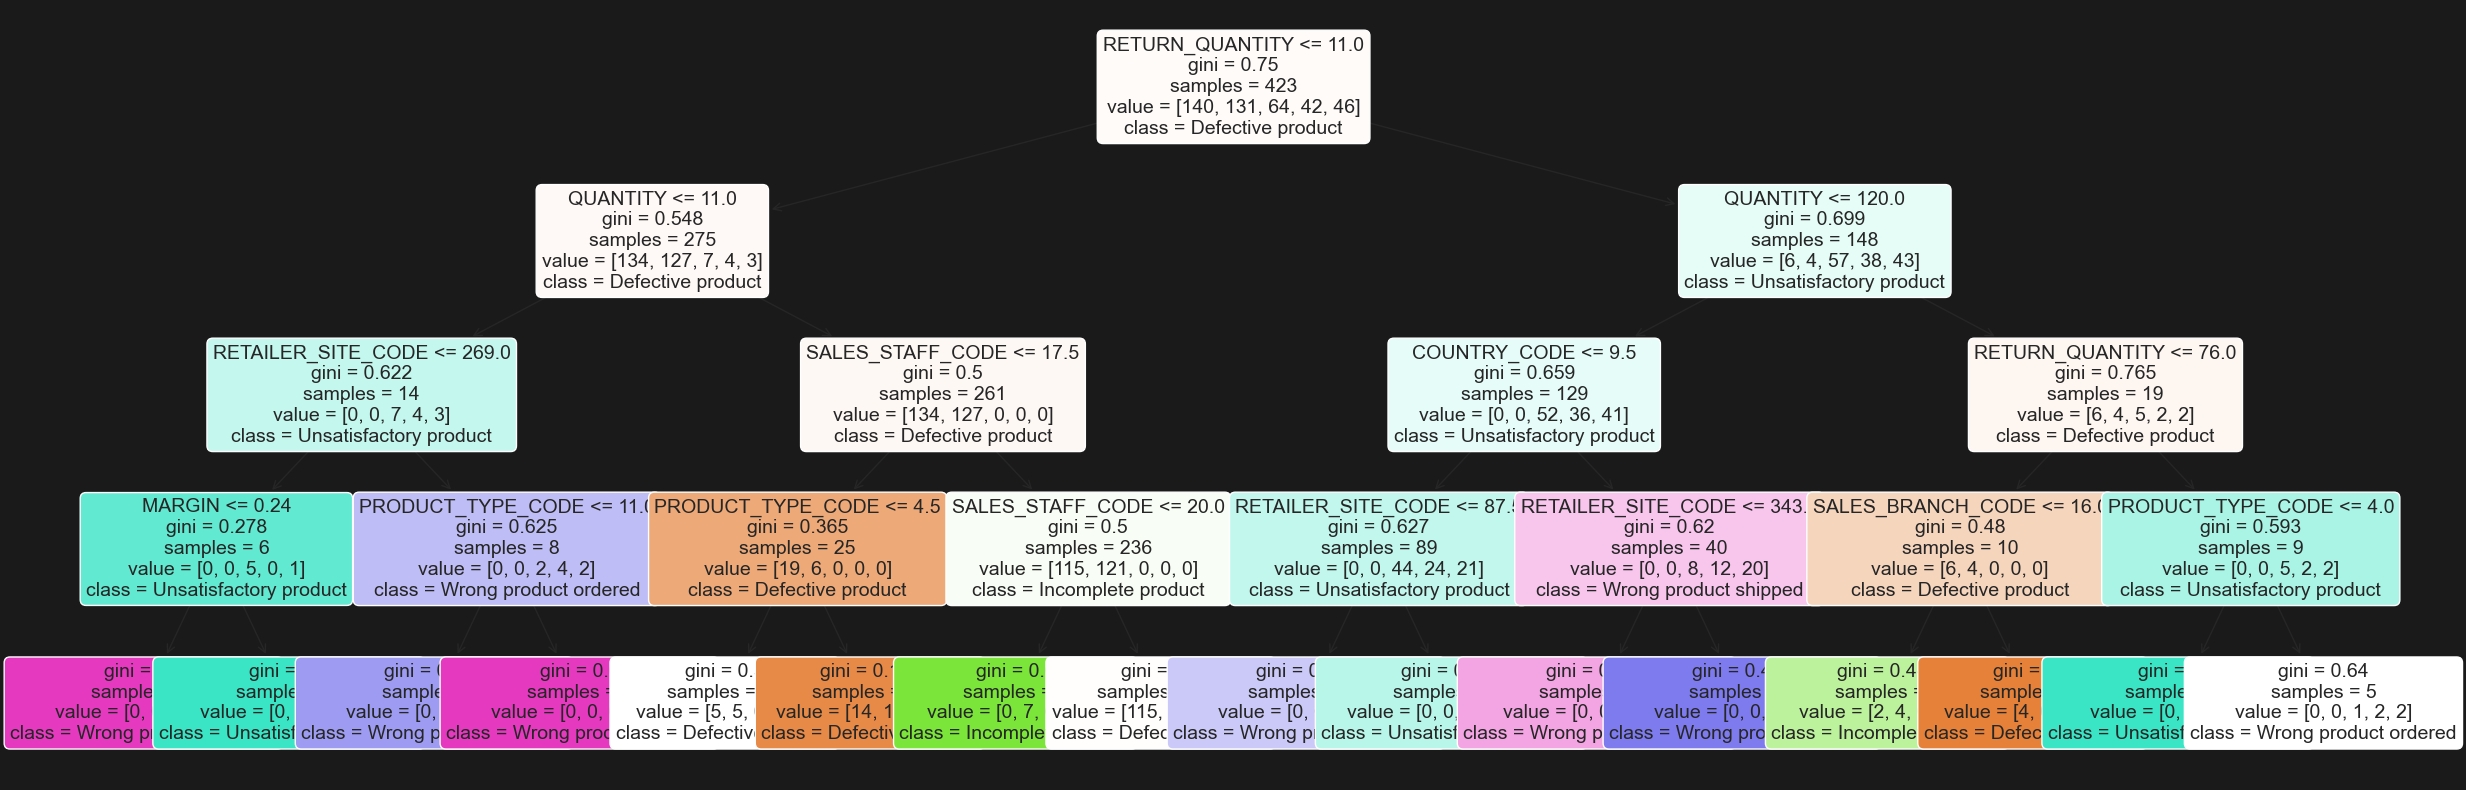

In [161]:
plt.figure(figsize=(30,10), facecolor ='k')
a = tree.plot_tree(clf, feature_names = feature_names, class_names = labels, rounded = True, filled = True, fontsize=14)
plt.show()

##### 2. As a Text-Based Diagram

In [162]:
tree_rules = export_text(clf, feature_names = list(feature_names))
print(tree_rules)

|--- RETURN_QUANTITY <= 11.00
|   |--- QUANTITY <= 11.00
|   |   |--- RETAILER_SITE_CODE <= 269.00
|   |   |   |--- MARGIN <= 0.24
|   |   |   |   |--- class: Wrong product shipped
|   |   |   |--- MARGIN >  0.24
|   |   |   |   |--- class: Unsatisfactory product
|   |   |--- RETAILER_SITE_CODE >  269.00
|   |   |   |--- PRODUCT_TYPE_CODE <= 11.00
|   |   |   |   |--- class: Wrong product ordered
|   |   |   |--- PRODUCT_TYPE_CODE >  11.00
|   |   |   |   |--- class: Wrong product shipped
|   |--- QUANTITY >  11.00
|   |   |--- SALES_STAFF_CODE <= 17.50
|   |   |   |--- PRODUCT_TYPE_CODE <= 4.50
|   |   |   |   |--- class: Defective product
|   |   |   |--- PRODUCT_TYPE_CODE >  4.50
|   |   |   |   |--- class: Defective product
|   |   |--- SALES_STAFF_CODE >  17.50
|   |   |   |--- SALES_STAFF_CODE <= 20.00
|   |   |   |   |--- class: Incomplete product
|   |   |   |--- SALES_STAFF_CODE >  20.00
|   |   |   |   |--- class: Defective product
|--- RETURN_QUANTITY >  11.00
|   |--- QUANT

##### Make and format a confusion matrix

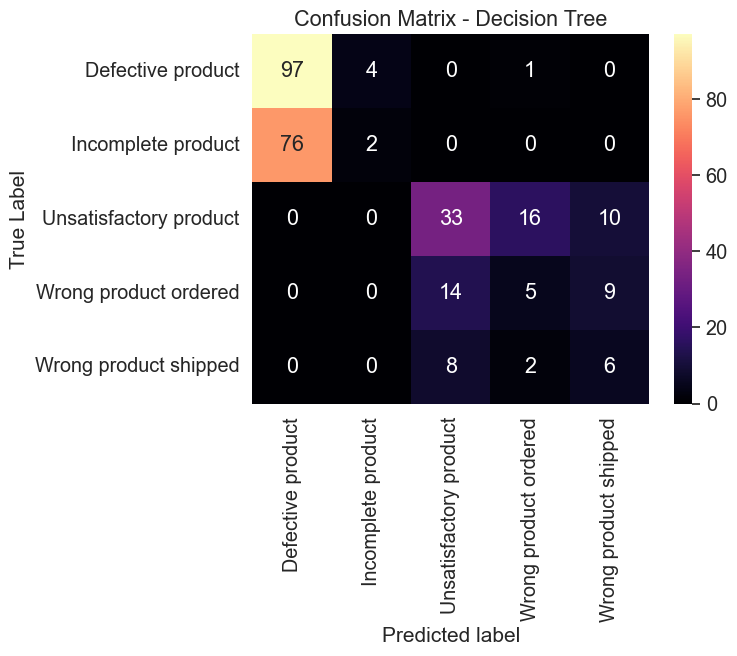

<Figure size 1000x700 with 0 Axes>

In [163]:
test_pred_decision_tree = clf.predict(X_test)

# Make this template a function for reusability
def generateConfusionMatrix(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    matrix_df = pd.DataFrame(cm)
    ax = plt.axes()

    sns.set(font_scale=1.3)
    plt.figure(figsize=(10,7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_title('Confusion Matrix - Decision Tree')
    ax.set_xlabel("Predicted label", fontsize =15)
    ax.set_xticklabels(['']+labels, rotation = 90)
    ax.set_ylabel("True Label", fontsize=15)
    ax.set_yticklabels(list(labels), rotation = 0)

    plt.show()
    

generateConfusionMatrix(y_test, test_pred_decision_tree)

# Random Forest

##### Import additional libraries and required data

In [164]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

##### Fit the model

In [165]:
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(x, y)

##### Generate Statistics

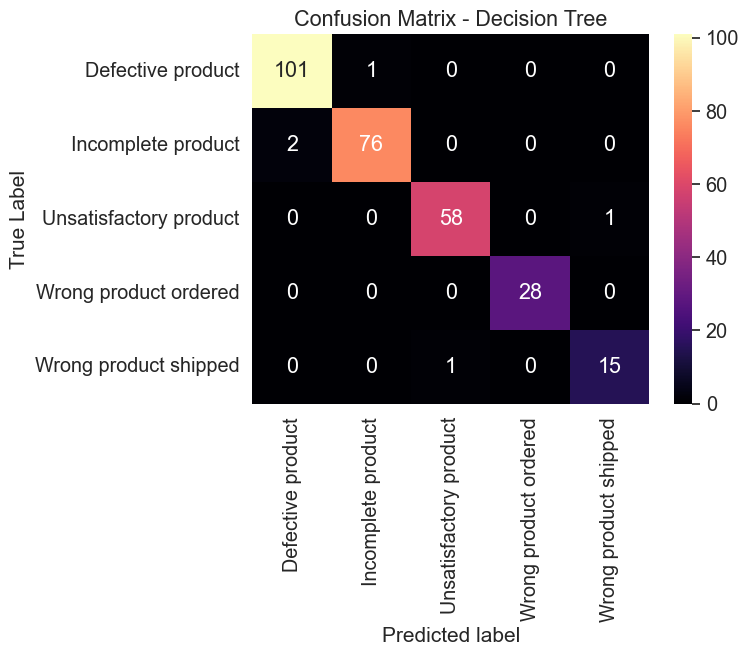

<Figure size 1000x700 with 0 Axes>

In [166]:
y_pred = clf.predict(X_test)

# Reuse earlier confusion matrix code
generateConfusionMatrix(y_test, y_pred)

In [167]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9823321554770318
Precision: 0.982354877960216
Recall: 0.9823321554770318
